In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import hdbscan as HD
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tuning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tuning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [5]:
dict_embedding = {}
dict_embedding["WMD"] = dict_wmd_embedding
dict_embedding["Moyenne"] = dict_moy_embedding

In [6]:
df_hdbscan_clustering = pd.read_csv("data/tuning/clustering/hdbscan.csv",sep=";")
df_hdbscan_clustering["clustering"] = "hdbscan"
df_hdbscan_clustering["K"]  = df_hdbscan_clustering["K"] - 1
df_kmeans_clustering = pd.read_csv("data/tuning/clustering/kmeans.csv",sep=";")
df_gmm_clustering = pd.read_csv("data/tuning/clustering/gmm.csv",sep=";")
df_gmm_clustering["clustering"] = "gmm"
df_clustering = pd.concat([df_hdbscan_clustering,df_kmeans_clustering,df_gmm_clustering])
df_clustering = df_clustering[df_clustering["K"]>=5]
df_clustering = df_clustering[df_clustering["K"]<=20]
df_clustering["silhouette-DBCV"] = df_clustering[["silhouette","DBCV"]].apply(np.mean,axis=1)
df_clustering.head()

voisinage  min_cluster_size     distance  K  silhouette  Cal-Harabasz  \
41       20.0              11.0  precomputed  5    0.321917           NaN   
42       20.0              12.0  precomputed  5    0.321917           NaN   
51       19.0              10.0  precomputed  5    0.315283           NaN   
60       10.0              10.0  precomputed  5    0.340517           NaN   
81       42.0              10.0  precomputed  5    0.303762           NaN   

        DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
41  0.119809        671.0         NaN          cbow          WMD   
42  0.119809        671.0         NaN          cbow          WMD   
51  0.114788        680.0         NaN          cbow          WMD   
60  0.108204        580.0         NaN          cbow          WMD   
81  0.089011        695.0         NaN          cbow          WMD   

   docEmbedding2 clustering initialisation  nb_iter  tolerance  val_obj  \
41      Distance    hdbscan            NaN      NaN        NaN      NaN   
42      Distance    hdbscan            NaN      NaN        NaN      NaN   
51      Distance    hdbscan            NaN      NaN        NaN      NaN   
60      Distance    hdbscan            NaN      NaN        NaN      NaN   
81      Distance    hdbscan            NaN      NaN        NaN      NaN   

   covariance  BIC  silhouette-DBCV  
41        NaN  NaN         0.220863  
42        NaN  NaN         0.220863  
51        NaN  NaN         0.215035  
60        NaN  NaN         0.224361  
81        NaN  NaN         0.196387

# Clustering Avant Tsne

In [7]:
df_clustering_before = df_clustering.loc[(df_clustering["perplexity"].isna())].reset_index()

In [8]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  Cal-Harabasz  \
252    186        NaN               NaN      NaN  5    0.405154  15339.302799   
312    578        NaN               NaN      NaN  5    0.035087    145.752720   
352    940        NaN               NaN      NaN  5    0.291723   5690.425304   

         DBCV  non_classes  perplexity  ... docEmbedding docEmbedding2  \
252 -0.753192          NaN         NaN  ...      Moyenne         TFIDF   
312 -0.697669          NaN         NaN  ...      Moyenne            TF   
352 -0.805468          NaN         NaN  ...      Moyenne         TFIDF   

    clustering initialisation nb_iter  tolerance     val_obj  covariance BIC  \
252     kmeans         random    10.0     0.0001  396.232829         NaN NaN   
312     kmeans      k-means++    10.0     0.0001    0.417098         NaN NaN   
352     kmeans         random    10.0     0.0001  604.194378         NaN NaN   

     silhouette-DBCV  
252        -0.174019  
312        -0.331291  
352        -0.256873  

[3 rows x 21 columns]

In [9]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size   distance  K  silhouette  \
253    187        NaN               NaN        NaN  5    0.405681   
702   1810        NaN               NaN        NaN  5    0.160676   
99   22141        6.0              10.0  euclidean  5    0.481659   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
253  15337.873936 -0.749637          NaN         NaN  ...      Moyenne   
702     48.114086 -0.616269          NaN         NaN  ...      Moyenne   
99     489.760064 -0.248700        579.0         NaN  ...      Moyenne   

    docEmbedding2 clustering initialisation nb_iter  tolerance     val_obj  \
253         TFIDF     kmeans      k-means++    10.0     0.0001  396.268091   
702         TFIDF        gmm            NaN     NaN        NaN         NaN   
99          TFIDF    hdbscan            NaN     NaN        NaN         NaN   

     covariance           BIC  silhouette-DBCV  
253         NaN           NaN        -0.171978  
702        full -3.130738e+07        -0.227796  
99          NaN           NaN         0.116480  

[3 rows x 21 columns]

In [10]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
0       41       20.0              11.0  precomputed   5    0.321917   
67   10714        3.0              11.0    euclidean  11   -0.143543   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
0             NaN  0.119809        671.0         NaN  ...          WMD   
67      12.868416  0.003273       9215.0         NaN  ...      Moyenne   
179           NaN  0.278496        481.0         NaN  ...          WMD   

    docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
0        Distance    hdbscan            NaN     NaN        NaN      NaN   
67             TF    hdbscan            NaN     NaN        NaN      NaN   
179      Distance    hdbscan            NaN     NaN        NaN      NaN   

     covariance BIC  silhouette-DBCV  
0           NaN NaN         0.220863  
67          NaN NaN        -0.070135  
179         NaN NaN         0.232923  

[3 rows x 21 columns]

In [11]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette-DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
3       60       10.0              10.0  precomputed   5    0.340517   
687   1789        NaN               NaN          NaN  10    0.121942   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
3             NaN  0.108204        580.0         NaN  ...          WMD   
687     40.366338       NaN          NaN         NaN  ...      Moyenne   
179           NaN  0.278496        481.0         NaN  ...          WMD   

    docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
3        Distance    hdbscan            NaN     NaN        NaN      NaN   
687         TFIDF        gmm            NaN     NaN        NaN      NaN   
179      Distance    hdbscan            NaN     NaN        NaN      NaN   

     covariance           BIC  silhouette-DBCV  
3           NaN           NaN         0.224361  
687        diag -3.327373e+07         0.121942  
179         NaN           NaN         0.232923  

[3 rows x 21 columns]

# Clustering Apres Tsne

In [12]:
df_clustering_after = df_clustering.loc[(df_clustering["perplexity"]==200)].reset_index().drop(columns="index")

In [13]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

voisinage  min_cluster_size distance   K  silhouette  Cal-Harabasz  \
2058        NaN               NaN      NaN  14    0.404300  24527.133503   
2238        NaN               NaN      NaN  13    0.367643   8870.307615   
2138        NaN               NaN      NaN  14    0.383962  14189.799335   

          DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
2058 -0.618270          NaN       200.0          cbow      Moyenne   
2238 -0.767586          NaN       200.0         glove          WMD   
2138 -0.630786          NaN       200.0      skipgram      Moyenne   

     docEmbedding2 clustering initialisation  nb_iter  tolerance  \
2058         TFIDF     kmeans      k-means++     10.0     0.0001   
2238      Distance     kmeans      k-means++     10.0     0.0001   
2138         TFIDF     kmeans         random     10.0     0.0001   

            val_obj covariance  BIC  silhouette-DBCV  
2058  254537.359375        NaN  NaN        -0.106985  
2238  431840.343750        NaN  NaN        -0.199972  
2138  345745.093750        NaN  NaN        -0.123412

In [14]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["DBCV"].idxmax()]

voisinage  min_cluster_size   distance  K  silhouette  Cal-Harabasz  \
474      200.0              11.0  euclidean  5    0.011078   1293.057139   
241      200.0             100.0  euclidean  5   -0.220725    452.810222   
985      150.0              11.0  euclidean  8   -0.293709    910.314885   

         DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
474  0.139012       4305.0       200.0          cbow          WMD   
241  0.110888       6675.0       200.0         glove          WMD   
985  0.107625       5228.0       200.0      skipgram      Moyenne   

    docEmbedding2 clustering initialisation  nb_iter  tolerance  val_obj  \
474           MDS    hdbscan            NaN      NaN        NaN      NaN   
241      Distance    hdbscan            NaN      NaN        NaN      NaN   
985         TFIDF    hdbscan            NaN      NaN        NaN      NaN   

    covariance  BIC  silhouette-DBCV  
474        NaN  NaN         0.075045  
241        NaN  NaN        -0.054918  
985        NaN  NaN        -0.093042

In [15]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["silhouette"].idxmax()]

voisinage  min_cluster_size distance  K  silhouette  Cal-Harabasz  \
2076        NaN               NaN      NaN  5    0.493015  20271.669489   
2254        NaN               NaN      NaN  6    0.372455   8367.525463   
2044        NaN               NaN      NaN  6    0.410946  11661.442514   

          DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
2076 -0.659591          NaN       200.0          cbow      Moyenne   
2254 -0.827066          NaN       200.0         glove          WMD   
2044 -0.613845          NaN       200.0      skipgram      Moyenne   

     docEmbedding2 clustering initialisation  nb_iter  tolerance      val_obj  \
2076         TFIDF     kmeans         random     10.0     0.0001  923538.3125   
2254      Distance     kmeans         random     10.0     0.0001  975984.5625   
2044            TF     kmeans      k-means++     10.0     0.0001  820455.9375   

     covariance  BIC  silhouette-DBCV  
2076        NaN  NaN        -0.083288  
2254        NaN  NaN        -0.227305  
2044        NaN  NaN        -0.101449

In [16]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette-DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
3       60       10.0              10.0  precomputed   5    0.340517   
687   1789        NaN               NaN          NaN  10    0.121942   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity  ... docEmbedding  \
3             NaN  0.108204        580.0         NaN  ...          WMD   
687     40.366338       NaN          NaN         NaN  ...      Moyenne   
179           NaN  0.278496        481.0         NaN  ...          WMD   

    docEmbedding2 clustering initialisation nb_iter  tolerance  val_obj  \
3        Distance    hdbscan            NaN     NaN        NaN      NaN   
687         TFIDF        gmm            NaN     NaN        NaN      NaN   
179      Distance    hdbscan            NaN     NaN        NaN      NaN   

     covariance           BIC  silhouette-DBCV  
3           NaN           NaN         0.224361  
687        diag -3.327373e+07         0.121942  
179         NaN           NaN         0.232923  

[3 rows x 21 columns]

# Plot ScatterPlot

In [25]:
def plot_best(df_clustering,dict_embedding,clustering_metric="silhouette",modele="cbow"):
    best_model = df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmin()] if clustering_metric == "BIC" else df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"
        first_reduce = best_model["perplexity"].notna().values[0]

        doc_embedding = dict_embedding[best_model["docEmbedding"].values[0]][modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)
        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])
        clustering_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]

        type_clustering = best_model["clustering"].values[0].upper()

        if type_clustering == "HDBSCAN":
            clust_model = HD.HDBSCAN(min_cluster_size=int(best_model["min_cluster_size"].values[0]), metric = best_model["distance"].values[0],min_samples=int(best_model["voisinage"].values[0]))
        elif type_clustering == "GMM":
            clust_model = GMM(n_components=best_model["K"].values[0],covariance_type=best_model["covariance"].values[0])
        elif type_clustering == "KMEANS":
            clust_model = KMeans(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0])
        elif type_clustering == "KMEDOIDES":
            clust_model = KMedoids(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0], metric = 'precomputed')

        labels = clust_model.fit_predict(np.array(clustering_data).astype(np.float64))

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        print(len(color_palette))
        print(np.unique(labels))
        
        cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]

        title = f"Best DocEmbedding Clustering based on {clustering_metric} metric from {type_clustering} algorithm"
        subtitle1 = f"WordEmbedding: {modele} - DocEmbedding: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - Reducing Before Clustering: {first_reduce}" 
        subtitle2 = f"Number of cluster: {len(np.unique(labels))} - Silhouette: {round(best_model['silhouette'].values[0],2)} - DBCV: {round(best_model['DBCV'].values[0],2)} - Calinski-Harabasz: {round(best_model['Cal-Harabasz'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

############################################################################################################################
                                                  GLOVE                                                                         
############################################################################################################################
5
[0 1 2 3 4]
12
[-1  0  1  2  3  4  5  6  7  8  9 10]
5
[0 1 2 3 4]
10
[0 1 2 3 4 5 6 7 8 9]


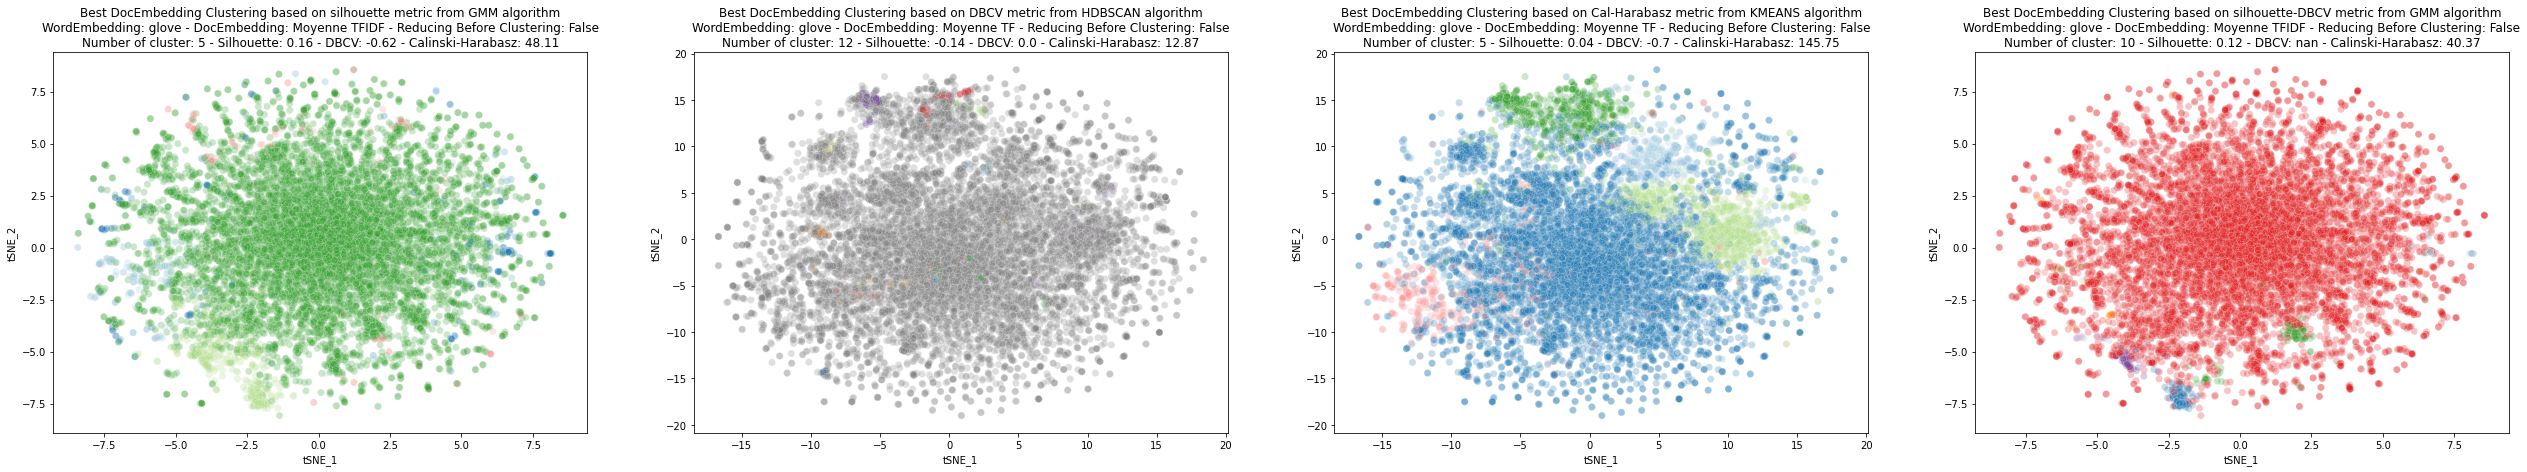

6
[0 1 2 3 4 5]
6
[-1  0  1  2  3  4]
13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
4
[-1  0  1  2]


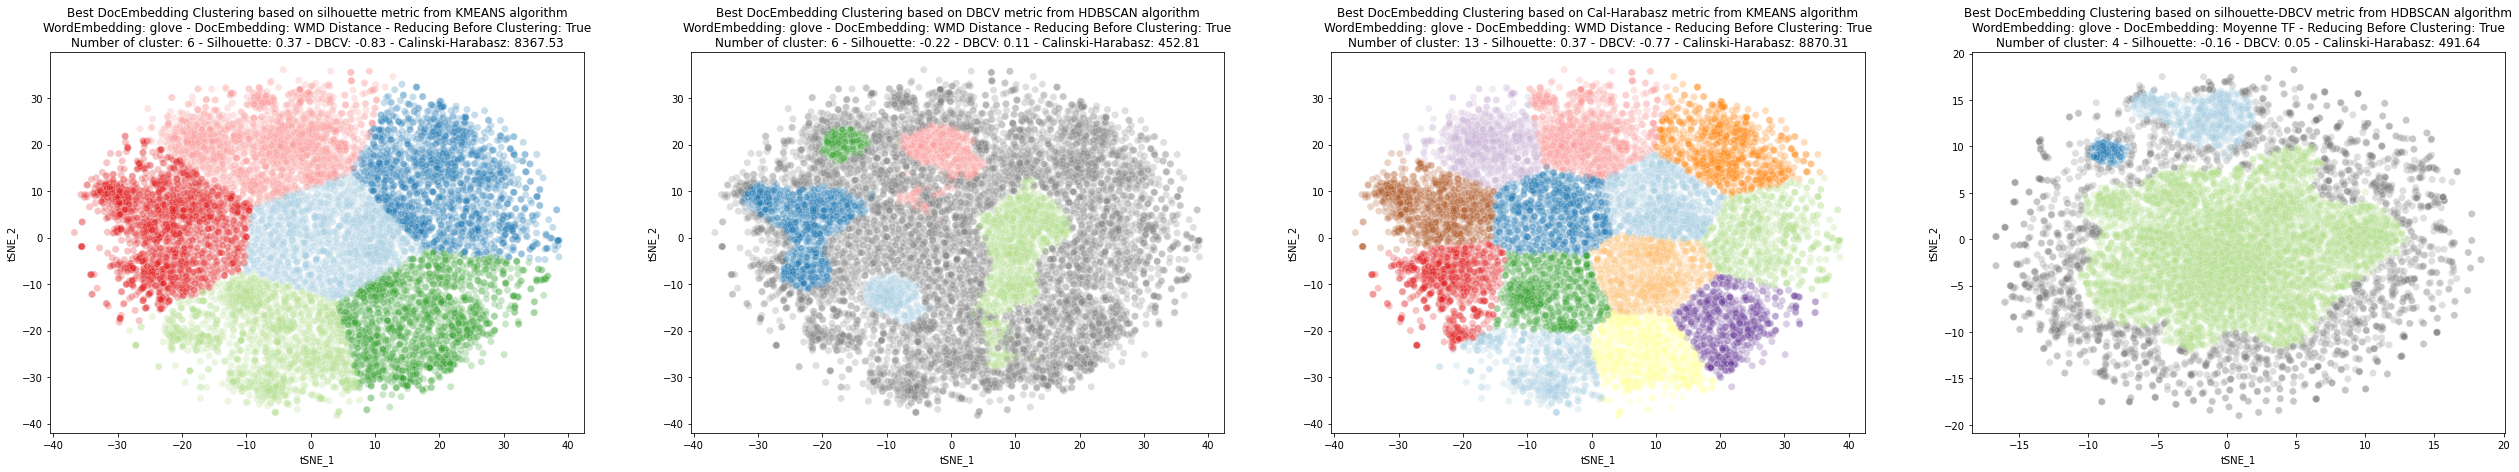

In [26]:
modele = "glove"
print("############################################################################################################################")
print(f"                                                  {modele.upper()}                                                                         ")
print("############################################################################################################################")
dict_label["ReductionFirst"][modele] = {}
dict_label["ReductionAfter"][modele] = {}
for type_reduction in ["ReductionAfter","ReductionFirst"]:
    all_metric = ["silhouette","DBCV", "Cal-Harabasz","silhouette-DBCV"]

    plt.figure(figsize = (44,7))
    for i in range(len(all_metric)):
        dict_label[type_reduction][modele][all_metric[i]] = {}
        #Silhouette
        if type_reduction == "ReductionAfter":
            Labels, Tsne, Colors, Title = plot_best(df_clustering_before,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        else:
            Labels, Tsne, Colors, Title = plot_best(df_clustering_after,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        
        filename = f"{modele}_{type_reduction.lower()}_{all_metric[i]}.csv"
        dict_label[type_reduction][modele][all_metric[i]]["labels"] = Labels
        dict_label[type_reduction][modele][all_metric[i]]["datafilename"] = filename
        pd.DataFrame(Tsne).to_csv(f"data/tuning/clustering/bestmodel/{filename}",sep=";",index=False)
        #plot
        sns.scatterplot(Tsne[:,0],Tsne[:,1], s=50, c=Colors, alpha=0.25,ax=plt.subplot(1,len(all_metric),i+1,title=Title,xlabel="tSNE_1",ylabel="tSNE_2"))
    plt.show()

In [18]:
# dict_label = {"ReductionFirst":{},"ReductionAfter":{}}

############################################################################################################################
                                                  SKIPGRAM                                                                         
############################################################################################################################


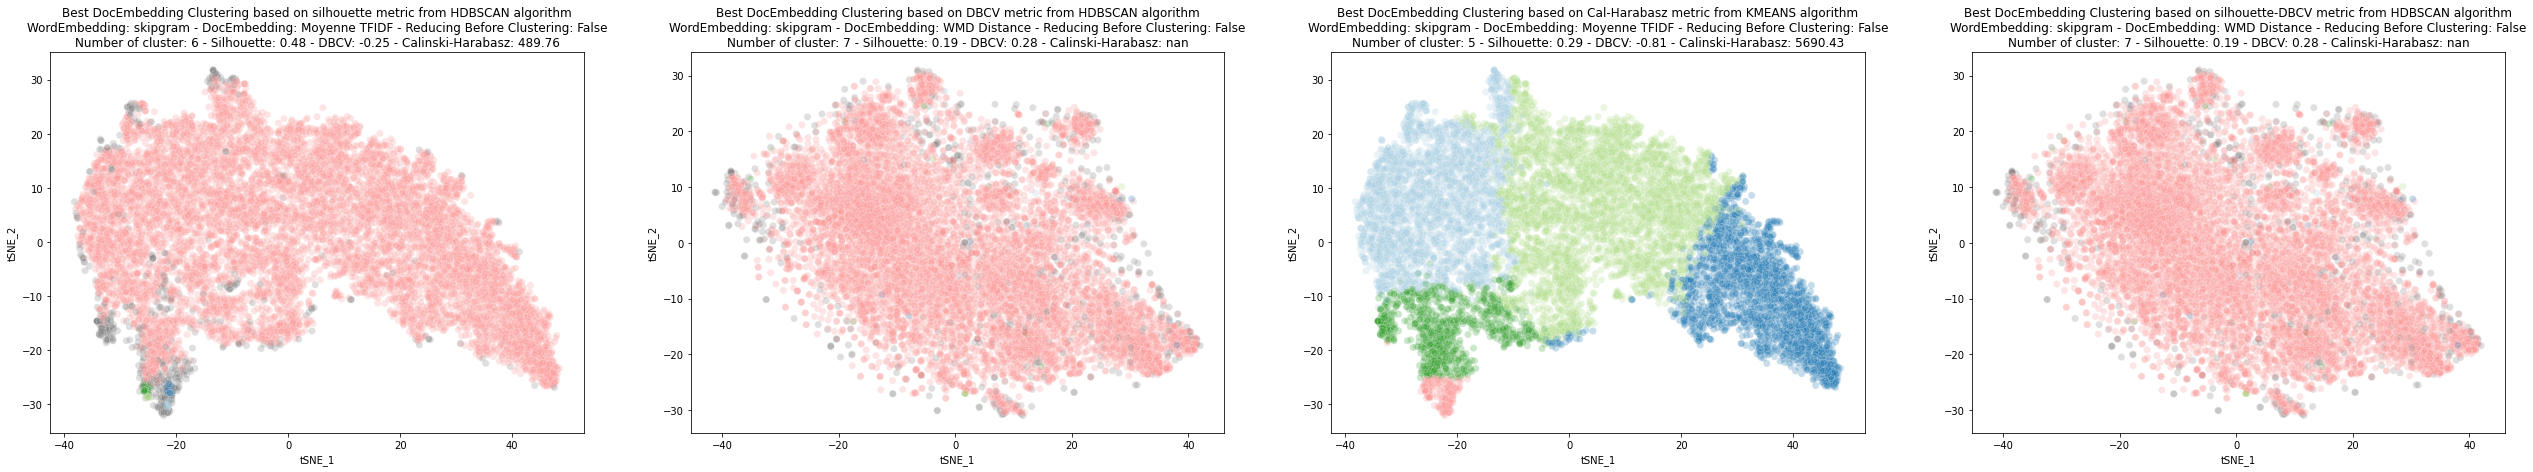

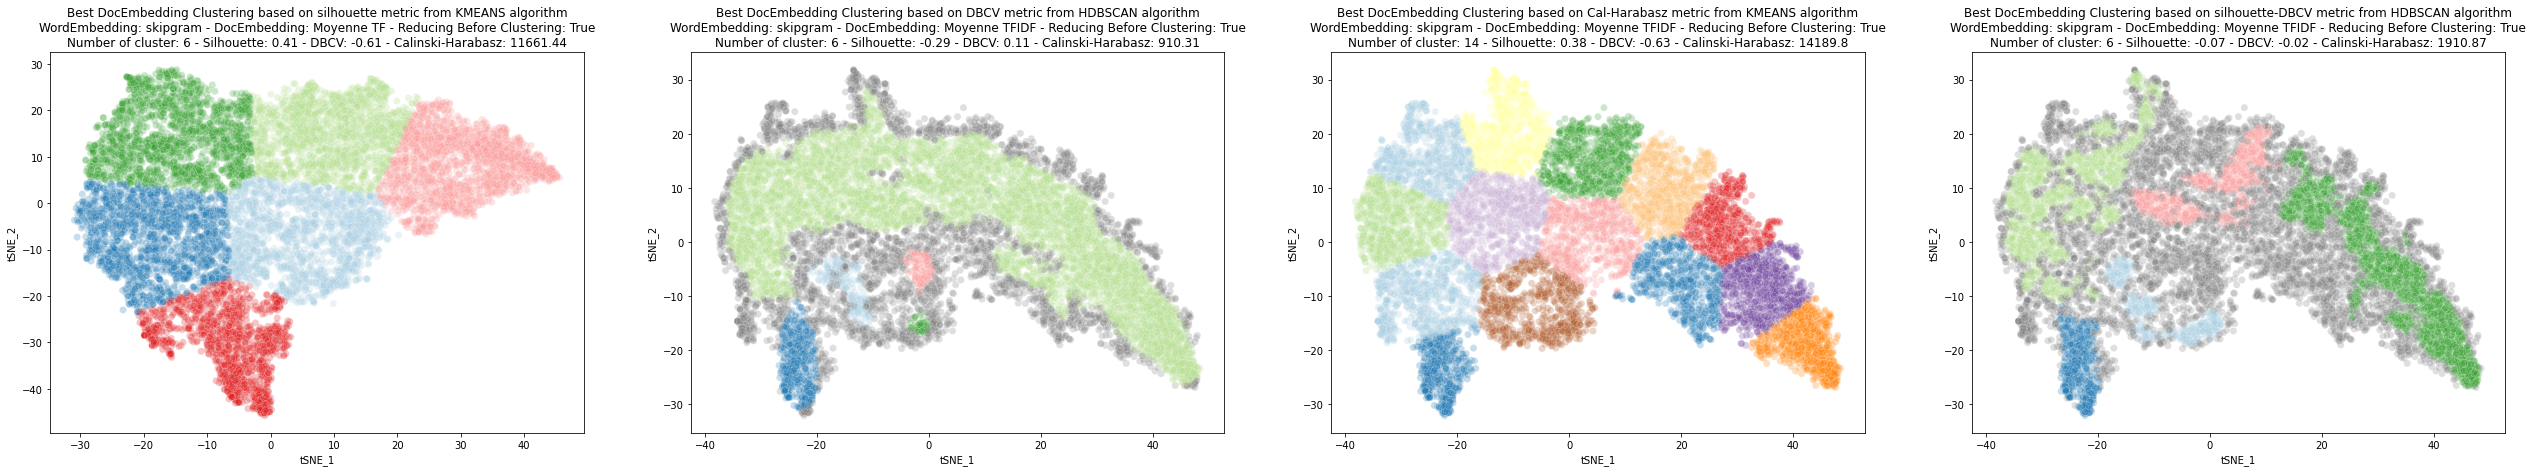

In [19]:
modele = "skipgram"
print("############################################################################################################################")
print(f"                                                  {modele.upper()}                                                                         ")
print("############################################################################################################################")
dict_label["ReductionFirst"][modele] = {}
dict_label["ReductionAfter"][modele] = {}
for type_reduction in ["ReductionAfter","ReductionFirst"]:
    all_metric = ["silhouette","DBCV", "Cal-Harabasz","silhouette-DBCV"]

    plt.figure(figsize = (44,7))
    for i in range(len(all_metric)):
        dict_label[type_reduction][modele][all_metric[i]] = {}
        #Silhouette
        if type_reduction == "ReductionAfter":
            Labels, Tsne, Colors, Title = plot_best(df_clustering_before,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        else:
            Labels, Tsne, Colors, Title = plot_best(df_clustering_after,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        
        filename = f"{modele}_{type_reduction.lower()}_{all_metric[i]}.csv"
        dict_label[type_reduction][modele][all_metric[i]]["labels"] = Labels
        dict_label[type_reduction][modele][all_metric[i]]["datafilename"] = filename
        pd.DataFrame(Tsne).to_csv(f"data/tuning/clustering/bestmodel/{filename}",sep=";",index=False)
        #plot
        sns.scatterplot(Tsne[:,0],Tsne[:,1], s=50, c=Colors, alpha=0.25,ax=plt.subplot(1,len(all_metric),i+1,title=Title,xlabel="tSNE_1",ylabel="tSNE_2"))
    plt.show()

############################################################################################################################
                                                  CBOW                                                                         
############################################################################################################################


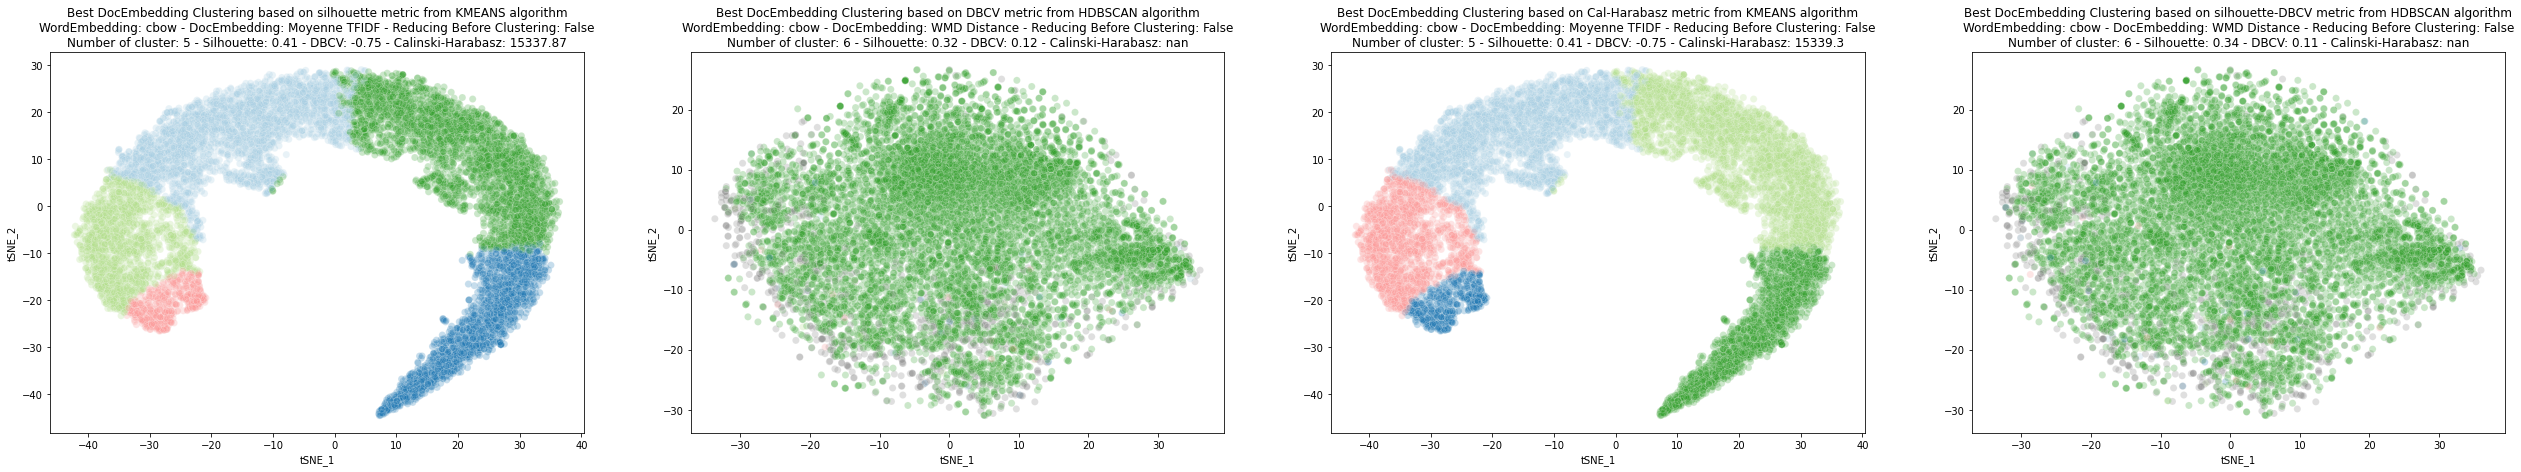

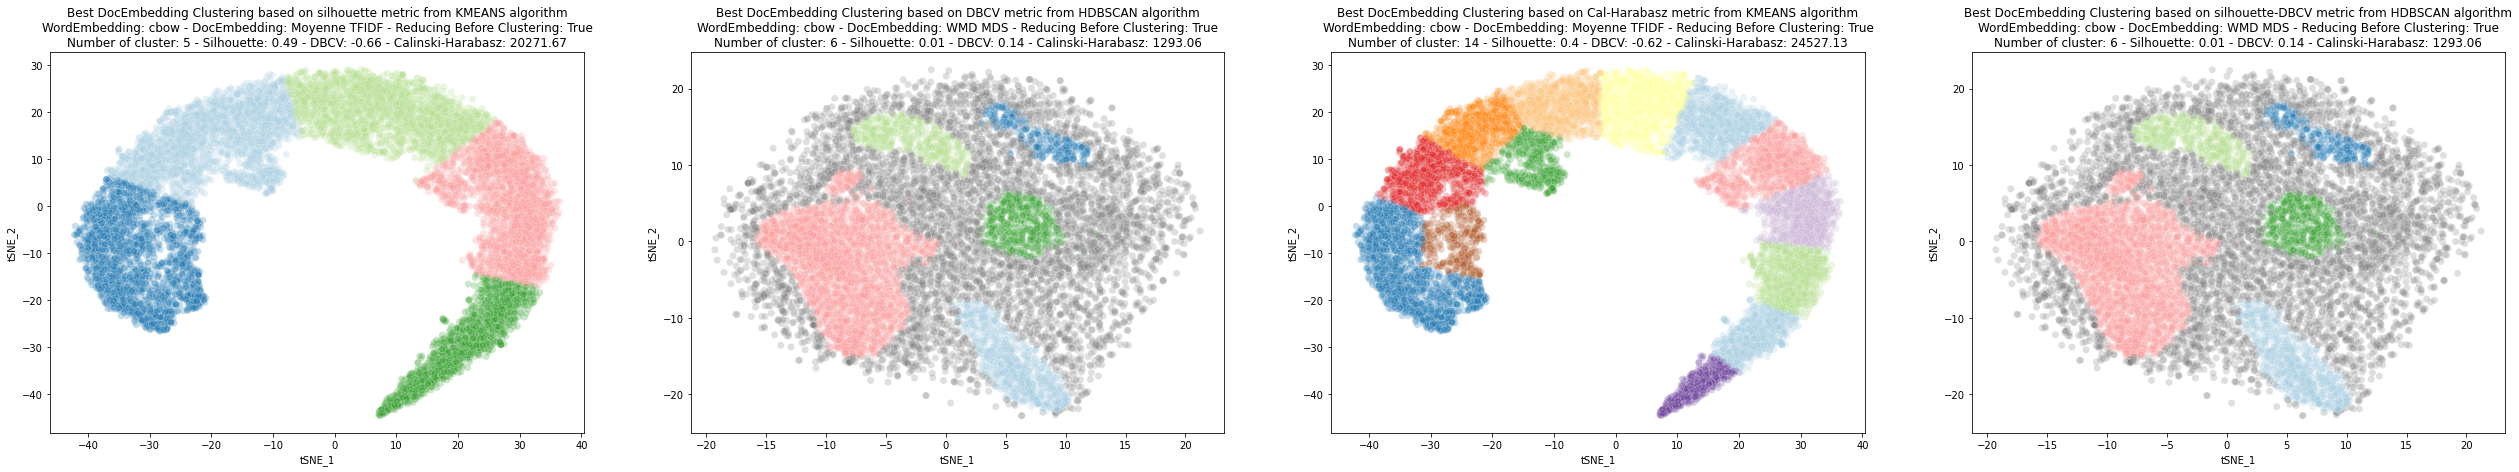

In [20]:
modele = "cbow"
print("############################################################################################################################")
print(f"                                                  {modele.upper()}                                                                         ")
print("############################################################################################################################")
dict_label["ReductionFirst"][modele] = {}
dict_label["ReductionAfter"][modele] = {}
for type_reduction in ["ReductionAfter","ReductionFirst"]:
    all_metric = ["silhouette","DBCV", "Cal-Harabasz","silhouette-DBCV"]

    plt.figure(figsize = (44,7))
    for i in range(len(all_metric)):
        dict_label[type_reduction][modele][all_metric[i]] = {}
        #Silhouette
        if type_reduction == "ReductionAfter":
            Labels, Tsne, Colors, Title = plot_best(df_clustering_before,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        else:
            Labels, Tsne, Colors, Title = plot_best(df_clustering_after,dict_embedding,clustering_metric=all_metric[i],modele=modele)
        
        filename = f"{modele}_{type_reduction.lower()}_{all_metric[i]}.csv"
        dict_label[type_reduction][modele][all_metric[i]]["labels"] = Labels
        dict_label[type_reduction][modele][all_metric[i]]["datafilename"] = filename
        pd.DataFrame(Tsne).to_csv(f"data/tuning/clustering/bestmodel/{filename}",sep=";",index=False)
        #plot
        sns.scatterplot(Tsne[:,0],Tsne[:,1], s=50, c=Colors, alpha=0.25,ax=plt.subplot(1,len(all_metric),i+1,title=Title,xlabel="tSNE_1",ylabel="tSNE_2"))
    plt.show()

In [ ]:
with open("data/tuning/clustering/best_labels.json", encoding = "utf8") as f:
    dict_label2 = json.load(f)

In [ ]:
import copy
dict_label_copy = copy.deepcopy(dict_label)
for key1 in dict_label_copy.keys():
    for key2 in dict_label_copy[key1].keys():
        for key3 in dict_label_copy[key1][key2].keys():
            dict_label_copy[key1][key2][key3]["labels"] = list(dict_label_copy[key1][key2][key3]["labels"])
            # print(list(dict_label_copy[key1][key2][key3]["labels"]))

In [ ]:
def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError
saveLabel=True
if saveLabel:
    with open("data/tuning/clustering/best_labels.json", "w") as output_file:
        json.dump(dict_label_copy,output_file,default=convert)